In [1]:
import warnings
import pandas as pd
import numpy as np
import nltk
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import random
# import os
# import re
# import math
# from sqlalchemy import create_engine
# import pymysql
# import requests
# from bs4 import BeautifulSoup
# from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.ar_model import AR
# from statsmodels.tools.eval_measures import rmse
# from scipy import stats

In [2]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [3]:
df_cons = pd.read_csv('./clean_data/clean_data.csv')
df_cons.drop('Unnamed: 0', axis=1, inplace=True)

### Step 1: transform dataset:
- each cocktail = one row
- all ingredients generalized and combined in one column

In [4]:
# Reduce dataset to only the columns required for current step

df = df_cons[['strDrink', 'Alc_type', 'Basic_taste']]

In [5]:
# Replace nan values with empty string to align data type for every value

df.fillna('', inplace=True)

In [6]:
# Replace ' ' with '_' to keep adjectives with nouns

df['Alc_type'] = df['Alc_type'].apply(lambda x: x.replace(' ', '_'))

In [7]:
# Reallocate ingredients as columns so each column takes only one row

df = df[df['Alc_type'] != 'Alc_type']
s =  df.groupby('strDrink').cumcount().add(1)
df = (df.set_index(['strDrink',s])
        .unstack()
        .sort_index(axis=1, level=1)
       )
df.columns = ['{}_{}'.format(a, b) for a,b in df.columns]

df = df.reset_index()
df.head()

,strDrink,Alc_type_1,Basic_taste_1,Alc_type_2,Basic_taste_2,Alc_type_3,Basic_taste_3,Alc_type_4,Basic_taste_4,Alc_type_5,Basic_taste_5,Alc_type_6,Basic_taste_6,Alc_type_7,Basic_taste_7,Alc_type_8,Basic_taste_8,Alc_type_9,Basic_taste_9,Alc_type_10,Basic_taste_10,Alc_type_11,Basic_taste_11
0,'57 Chevy with a White License Plate,Creamy_Liqueur,,Vodka,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-900-FUK-MEUP,Vodka,,Triple_Sec,,Sweet_Liqueur,,Sweet_Liqueur,,Rum,,Sweet_Liqueur,,,sour,,sweet,NaN,NaN,NaN,NaN,NaN,NaN
2,110 in the shade,Beer,,Tequila,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,151 Florida Bushwacker,Rum,,Rum,,Rum,,Creamy_Liqueur,,Triple_Sec,,,cream,Sweet_Liqueur,,,cream,NaN,NaN,NaN,NaN,NaN,NaN
4,155 Belmont,Rum,,Rum,,Vodka,,,sweet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df['Ingredients'] = df.drop(['strDrink'], axis=1).fillna('').apply(lambda x: ' '.join(x), axis=1).apply(lambda x: x.lower())
df = df[['strDrink', 'Ingredients']]

In [9]:
df.head()

,strDrink,Ingredients
0,'57 Chevy with a White License Plate,creamy_liqueur vodka
1,1-900-FUK-MEUP,vodka triple_sec sweet_liqueur sweet_liqueu...
2,110 in the shade,beer tequila
3,151 Florida Bushwacker,rum rum rum creamy_liqueur triple_sec cr...
4,155 Belmont,rum rum vodka sweet


### Step 2:
- split ingerients by pairs
- compute most common pairs (N - to be defined depending on results)

In [10]:
# Generate pairs from ingredients of each cocktail and combine them in one list

bigram = [list(nltk.bigrams(nltk.word_tokenize(i))) for i in df['Ingredients']]
pairs_list = [j for i in bigram for j in i]
print(len(pairs_list))
pairs_list[:10]

1308


[('creamy_liqueur', 'vodka'),
 ('vodka', 'triple_sec'),
 ('triple_sec', 'sweet_liqueur'),
 ('sweet_liqueur', 'sweet_liqueur'),
 ('sweet_liqueur', 'rum'),
 ('rum', 'sweet_liqueur'),
 ('sweet_liqueur', 'sour'),
 ('sour', 'sweet'),
 ('beer', 'tequila'),
 ('rum', 'rum')]

There are some tuples where elements are swopped but essential taste of such combination is not unique. Such tuples need to be alighned.

In [11]:
# First, define a list of tuples to be amended

to_aligh = []
for a in pairs_list:
    for b in pairs_list:
        if a != b:
            if b[1] == a[0]:
                if b[0] == a[1]:            # If both elements of tuple are equal to the swopped tuple under the check
                    if a not in to_aligh and b not in to_aligh:
                        to_aligh.append(b)

In [12]:
# Second, amend them

pairs_list_aligned = []
for i in pairs_list:
    if i in to_aligh:
        pairs_list_aligned.append((i[1], i[0]))
    else:
        pairs_list_aligned.append(i)

In [13]:
# Check that total number of tuples hasn't changed, only content should be amended

len(pairs_list_aligned) == len(pairs_list)

True

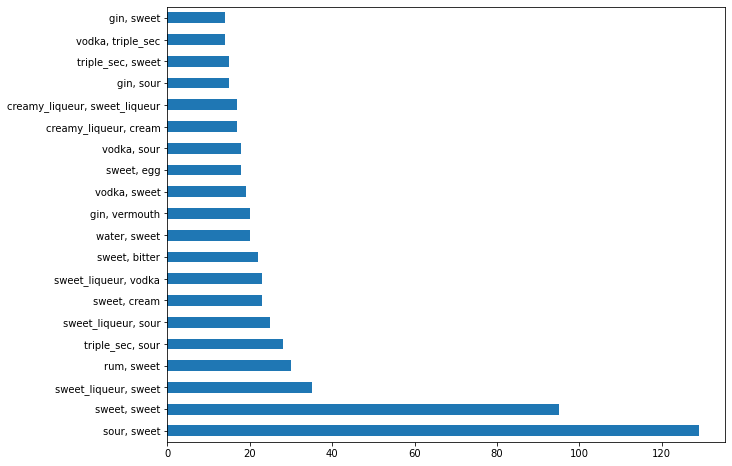

In [14]:
# Plot the most common pairs

pairs_list_flat = [(i[0]+', '+i[1]) for i in pairs_list_aligned]
pairs = pd.DataFrame(pairs_list_flat, columns=['pairs'])
plt.figure(figsize = (10,8))
ax = pairs['pairs'].value_counts().nlargest(20).plot.barh()
plt.show()

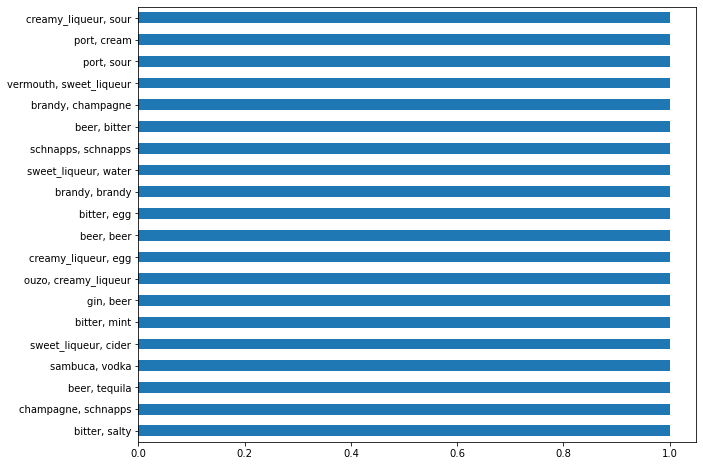

In [15]:
# Plot the least common pairs

plt.figure(figsize = (10,8))
ax = pairs['pairs'].value_counts().nsmallest(20).plot.barh()
plt.show()

In [16]:
# Define 25% of the most common pairs as a separate list

counter=collections.Counter(pairs_list_aligned)
print(len(counter))
common_pairs = counter.most_common(int(len(counter)*0.25))
common_pairs

205


[(('sour', 'sweet'), 129),
 (('sweet', 'sweet'), 95),
 (('sweet_liqueur', 'sweet'), 35),
 (('rum', 'sweet'), 30),
 (('triple_sec', 'sour'), 28),
 (('sweet_liqueur', 'sour'), 25),
 (('sweet_liqueur', 'vodka'), 23),
 (('sweet', 'cream'), 23),
 (('sweet', 'bitter'), 22),
 (('gin', 'vermouth'), 20),
 (('water', 'sweet'), 20),
 (('vodka', 'sweet'), 19),
 (('vodka', 'sour'), 18),
 (('sweet', 'egg'), 18),
 (('creamy_liqueur', 'sweet_liqueur'), 17),
 (('creamy_liqueur', 'cream'), 17),
 (('triple_sec', 'sweet'), 15),
 (('gin', 'sour'), 15),
 (('vodka', 'triple_sec'), 14),
 (('gin', 'sweet'), 14),
 (('whisky', 'sour'), 14),
 (('gin', 'triple_sec'), 13),
 (('sour', 'sour'), 13),
 (('creamy_liqueur', 'creamy_liqueur'), 12),
 (('sweet_liqueur', 'bitter'), 12),
 (('rum', 'sour'), 12),
 (('triple_sec', 'sweet_liqueur'), 11),
 (('rum', 'vodka'), 11),
 (('whisky', 'sweet_liqueur'), 11),
 (('sweet', 'brandy'), 11),
 (('cream', 'sweet_liqueur'), 10),
 (('gin', 'brandy'), 10),
 (('whisky', 'vermouth'), 10

In [17]:
common_ingredients = []

for n in common_pairs:
    common_ingredients.append(n[0][0])
    common_ingredients.append(n[0][1])
common_ingredients = list(set(common_ingredients))
common_ingredients

['beer',
 'water',
 'vodka',
 'gin',
 'bitter',
 'brandy',
 'sweet',
 'rum',
 'egg',
 'schnapps',
 'creamy_liqueur',
 'triple_sec',
 'salty',
 'sour',
 'sweet_liqueur',
 'whisky',
 'cream',
 'vermouth']

### Step 3: generate a frame for new combinations:
- define total number of ingerients (random choice from a range 3-6))
- from ingredients included in top pairs pick one randomly
- find suitable pair for this ingredient (from all pairs, but give top pairs bigger weight)
- do the same for the next ingredient but check that it's not included already
- etc until limit is reached

In [30]:
# Define total number of ingredients for a new cocktail

n_ingr = random.randint(3,7)

In [31]:
new_cocktail_frame = []

In [32]:
# Pick the first ingredient randomly from the top popular

first_ingr = random.choice(common_ingredients)
new_cocktail_frame.append(first_ingr)
first_ingr

'egg'

In [21]:
'''
Add weight to the most common combinations so they will come up more often but there'll still be a chance that less common
ingredient will be chosen.
'''

"\nAdd weight to the most common combinations so they will come up more often but there'll still be a chance that less common\ningredient will be chosen.\n"

In [33]:
# Identify remaning ingredients

counter = 1          # Not zero because the first ingredient is defined separatelly above
# print(f'Number of ingredients: {n_ingr}')    # Debugging
# print(f'New cocktail ingredients: {new_cocktail_frame}')    # Debugging
while counter < n_ingr:
    temp_list = []
#     print(f'New cocktail ingredients: {new_cocktail_frame}')    # Debugging
    for i in set(pairs_list_aligned):
        if new_cocktail_frame[-1] in i:
            temp_list.append(i)
    random_pair = random.choice(temp_list)
    if random_pair[0] == new_cocktail_frame[-1]:
        next_ingr = random_pair[1]
    else:
        next_ingr = random_pair[0]
    new_cocktail_frame.append(next_ingr)
#     print(f'Next ingredient to be added: {next_ingr}')    # Debugging
#     print(f'Counter: {counter}')    # Debugging
    counter += 1
# print(f'New cocktail ingredients: {new_cocktail_frame}')    # Debugging

In [34]:
new_cocktail_frame

['egg', 'port', 'rum', 'whisky', 'bitter', 'egg', 'beer']

### Step 4: fill new combinations with real ingredients:
- define list of ingredients for each basic taste
- randomly asign ingredients based on tastes in a frame

In [35]:
df_cons.head()

,strDrink,strCategory,strGlass,strIngredients,Alc_type,Basic_taste,strInstructions,strMeasures,Value,MeasureName,Value_numeric,Value_ml,Value_gr,Garnish_amount,Garnish_type,MeasureName_copy
0,'57 Chevy with a White License Plate,Cocktail,Highball glass,Creme De Cacao White,Creamy Liqueur,NaN,1. Fill a rocks glass with ice 2.add white cre...,1 oz white,1,oz,1.0,30.0,NaN,NaN,NaN,white
1,1-900-FUK-MEUP,Shot,Old-fashioned glass,Absolut Kurant,Vodka,NaN,Shake ingredients in a mixing tin filled with ...,1/2 oz,1/2,oz,0.5,15.0,NaN,NaN,NaN,oz
2,110 in the shade,Beer,Beer Glass,Lager,Beer,NaN,Drop shooter in glass. Fill with beer,16 oz,16,oz,16.0,480.0,NaN,NaN,NaN,oz
3,151 Florida Bushwacker,Milk / Float / Shake,Beer mug,Malibu Rum,Rum,NaN,Combine all ingredients. Blend until smooth. G...,1/2 oz,1/2,oz,0.5,15.0,NaN,NaN,NaN,oz
4,155 Belmont,Cocktail,White wine glass,Dark Rum,Rum,NaN,Blend with ice. Serve in a wine glass. Garnish...,1 shot,1,shot,1.0,25.0,NaN,NaN,NaN,shot


In [36]:
new_cocktail = []
for i in new_cocktail_frame:
    if len(df_cons.loc[df_cons['Basic_taste'] == i]['strIngredients'].unique()) == 0:
        new_cocktail.append(i)
    else:
        new_cocktail.append(random.choice(df_cons.loc[df_cons['Basic_taste'] == i]['strIngredients'].unique()))
new_cocktail

['Egg Yolk',
 'port',
 'rum',
 'whisky',
 'Tonic Water Schweppes',
 'Egg Yolk',
 'beer']

### How to implement measures?
(for this step it's better to exclude punches or rescale them somehow)